In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional
import torch

In [2]:
class NAGGS(torch.optim.Optimizer):
    """Class NAGGS implements algorithm 1 from [1] which stands for the Semi
    Implicit integration of the Nesterov Accelerated Gradient (NAG) flow.

     References
    ----------
    .. [1] NAG-GS: Semi-Implicit, Accelerated and Robust Stochastic Optimizer
    """

    def __init__(self, params, lr=1e-2, mu=1.0, gamma=1.0):
        if lr < 0.0:
            raise ValueError(f"Invalid alpha: {lr}")
        if mu < 0.0:
            raise ValueError(f"Invalid mu: {mu}")

        defaults = dict(lr=lr, mu=mu, gamma=gamma)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments
        ---------
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with T.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            v_list = []

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    grads.append(p.grad)

                    state = self.state[p]
                    # Initialization
                    if len(state) == 0:
                        state['v'] = torch.clone(p).detach()

                    v_list.append(state['v'])

            naggs(params_with_grad,
                 grads,
                 v_list,
                 alpha=group['lr'],
                 mu=group['mu'],
                 gamma=group['gamma'])

        return loss


def naggs(params: List[torch.Tensor], grads: List[torch.Tensor],
         v_list: List[Optional[torch.Tensor]], alpha: float, mu: float,
         gamma: float):
    """Function naggs performs NAGGS algorithm computation.
    """

    for i, param in enumerate(params):
        grad = grads[i]
        v = v_list[i]
        # Update v
        v.add_(mu*param - grad, alpha=alpha/gamma)
        v.div_(1 + alpha*mu/gamma)

        # Update parameters
        param.add_(v, alpha=alpha)
        param.div_(1+alpha)


In [12]:
torch.manual_seed(0)
n = 100
A = torch.randn(n, n).double()
Q, _ = torch.linalg.qr(A)
lmin = 1e-1
lmax = 100
Lambda = torch.linspace(lmin, lmax, steps=n).double()
A = Q @ torch.diag(Lambda) @ Q.t()
# A = A.t() @ A + torch.eye(n)
b = torch.randn(n).double()
spectrum = torch.linalg.eigvalsh(A)
print(spectrum)
print(spectrum.min().item(), spectrum.max().item(), spectrum.max().item() / 2, spectrum.max().item()/ spectrum.min().item())

tensor([  0.1000,   1.1091,   2.1182,   3.1273,   4.1364,   5.1455,   6.1545,
          7.1636,   8.1727,   9.1818,  10.1909,  11.2000,  12.2091,  13.2182,
         14.2273,  15.2364,  16.2455,  17.2545,  18.2636,  19.2727,  20.2818,
         21.2909,  22.3000,  23.3091,  24.3182,  25.3273,  26.3364,  27.3455,
         28.3545,  29.3636,  30.3727,  31.3818,  32.3909,  33.4000,  34.4091,
         35.4182,  36.4273,  37.4364,  38.4455,  39.4545,  40.4636,  41.4727,
         42.4818,  43.4909,  44.5000,  45.5091,  46.5182,  47.5273,  48.5364,
         49.5455,  50.5545,  51.5636,  52.5727,  53.5818,  54.5909,  55.6000,
         56.6091,  57.6182,  58.6273,  59.6364,  60.6455,  61.6545,  62.6636,
         63.6727,  64.6818,  65.6909,  66.7000,  67.7091,  68.7182,  69.7273,
         70.7364,  71.7455,  72.7545,  73.7636,  74.7727,  75.7818,  76.7909,
         77.8000,  78.8091,  79.8182,  80.8273,  81.8364,  82.8455,  83.8545,
         84.8636,  85.8727,  86.8818,  87.8909,  88.9000,  89.90

In [13]:
def quadratic_function(x):
    return 0.5 * x @ A @ x - b @ x

x_star = torch.linalg.solve(A, b)
f_star = quadratic_function(x_star)

In [14]:
x0 = torch.randn(n).double()
lr_range = torch.logspace(-3, 1, 70, dtype=torch.double)
num_iter_for_convergence = {}

In [15]:
eps = 1e-4
divergence_tol = 1e4

num_iter_for_convergence["NAG-GS"] = torch.zeros_like(lr_range)
for i, lr in enumerate(lr_range):
    print("# of lr = {}, lr = {}".format(i, lr.item()))
    x = torch.clone(x0)
    x.requires_grad_(True)
    nag_gs = NAGGS([x], lr=lr, mu=lmin, gamma=lmin)
    current_iter = 0
    while True:
        val = quadratic_function(x)
#         print((val - f_star).item())
        if abs(val - f_star) < eps:
            print("Converges for {} iterations".format(current_iter))
            num_iter_for_convergence["NAG-GS"][i] = current_iter
            break
        if abs(val - f_star) > divergence_tol:
            num_iter_for_convergence["NAG-GS"][i] = 1e10
            break
        val.backward()
        nag_gs.step()
        nag_gs.zero_grad()
        current_iter += 1
        

# of lr = 0, lr = 0.001
Converges for 8800 iterations
# of lr = 1, lr = 0.001142802059810032
Converges for 7701 iterations
# of lr = 2, lr = 0.0013059965479060534
Converges for 6739 iterations
# of lr = 3, lr = 0.0014924955450518291
Converges for 5898 iterations
# of lr = 4, lr = 0.0017056269831425286
Converges for 5161 iterations
# of lr = 5, lr = 0.0019491940296028525
Converges for 4517 iterations
# of lr = 6, lr = 0.0022275429519995563
Converges for 3953 iterations
# of lr = 7, lr = 0.002545640673860415
Converges for 3460 iterations
# of lr = 8, lr = 0.00290916340562388
Converges for 3028 iterations
# of lr = 9, lr = 0.0033245979322709418
Converges for 2650 iterations
# of lr = 10, lr = 0.0037993573650394056
Converges for 2320 iterations
# of lr = 11, lr = 0.004341913422721453
Converges for 2031 iterations
# of lr = 12, lr = 0.004961947603002903
Converges for 1777 iterations
# of lr = 13, lr = 0.0056705239413811686
Converges for 1556 iterations
# of lr = 14, lr = 0.00648028644041250

In [16]:
num_iter_for_convergence["GD"] = torch.zeros_like(lr_range)
for i, lr in enumerate(lr_range):
    print("# of lr = {}, lr = {}".format(i, lr.item()))
    x = torch.clone(x0)
    x.requires_grad_(True)
    sgd = torch.optim.SGD([x], lr=lr)
    current_iter = 0
    while True:
        val = quadratic_function(x)
#         print((val - f_star).item())
        if abs(val - f_star) < eps:
            print("Converges for {} iterations".format(current_iter))
            num_iter_for_convergence["GD"][i] = current_iter
            break
        if abs(val - f_star) > divergence_tol:
            num_iter_for_convergence["GD"][i] = 1e10
            break
        val.backward()
        sgd.step()
        sgd.zero_grad()
        current_iter += 1
        

# of lr = 0, lr = 0.001
Converges for 63540 iterations
# of lr = 1, lr = 0.001142802059810032
Converges for 55599 iterations
# of lr = 2, lr = 0.0013059965479060534
Converges for 48652 iterations
# of lr = 3, lr = 0.0014924955450518291
Converges for 42572 iterations
# of lr = 4, lr = 0.0017056269831425286
Converges for 37252 iterations
# of lr = 5, lr = 0.0019491940296028525
Converges for 32597 iterations
# of lr = 6, lr = 0.0022275429519995563
Converges for 28523 iterations
# of lr = 7, lr = 0.002545640673860415
Converges for 24959 iterations
# of lr = 8, lr = 0.00290916340562388
Converges for 21839 iterations
# of lr = 9, lr = 0.0033245979322709418
Converges for 19110 iterations
# of lr = 10, lr = 0.0037993573650394056
Converges for 16722 iterations
# of lr = 11, lr = 0.004341913422721453
Converges for 14632 iterations
# of lr = 12, lr = 0.004961947603002903
Converges for 12803 iterations
# of lr = 13, lr = 0.0056705239413811686
Converges for 11203 iterations
# of lr = 14, lr = 0.006

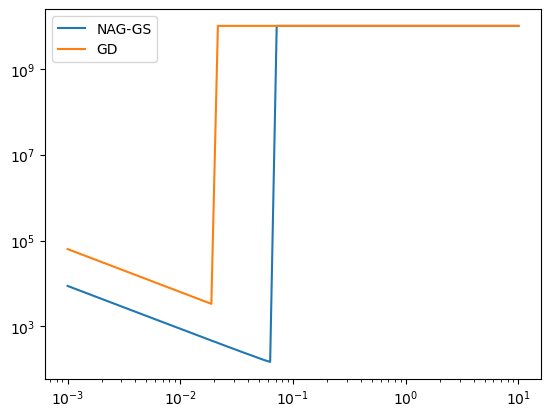

In [17]:
plt.loglog(lr_range, num_iter_for_convergence["NAG-GS"], label="NAG-GS")
plt.loglog(lr_range, num_iter_for_convergence["GD"], label="GD")
plt.legend()

In [18]:
# https://arxiv.org/pdf/1503.01243.pdf - Eq (1)
num_iter_for_convergence["AGD"] = torch.zeros_like(lr_range)
for i, lr in enumerate(lr_range):
    print("# of lr = {}, lr = {}".format(i, lr.item()))
    x = torch.clone(x0)
    y = torch.clone(x0)
    y.requires_grad_(True)

    current_iter = 0
    while True:
        val_y = quadratic_function(y)
        val_x = quadratic_function(x)
#         print((val - f_star).item())
        if abs(val_x - f_star) < eps:
            print("Converges for {} iterations".format(current_iter))
            num_iter_for_convergence["AGD"][i] = current_iter
            break
        if abs(val_x - f_star) > divergence_tol:
            num_iter_for_convergence["AGD"][i] = 1e10
            break
        val_y.backward()
        with torch.no_grad():
            x_next = y - lr * y.grad
            y = x_next + current_iter / (current_iter + 3) * (x_next - x)
            x = x_next
        y.requires_grad_(True)
        current_iter += 1

# of lr = 0, lr = 0.001
Converges for 700 iterations
# of lr = 1, lr = 0.001142802059810032
Converges for 654 iterations
# of lr = 2, lr = 0.0013059965479060534
Converges for 612 iterations
# of lr = 3, lr = 0.0014924955450518291
Converges for 573 iterations
# of lr = 4, lr = 0.0017056269831425286
Converges for 536 iterations
# of lr = 5, lr = 0.0019491940296028525
Converges for 501 iterations
# of lr = 6, lr = 0.0022275429519995563
Converges for 469 iterations
# of lr = 7, lr = 0.002545640673860415
Converges for 438 iterations
# of lr = 8, lr = 0.00290916340562388
Converges for 410 iterations
# of lr = 9, lr = 0.0033245979322709418
Converges for 384 iterations
# of lr = 10, lr = 0.0037993573650394056
Converges for 359 iterations
# of lr = 11, lr = 0.004341913422721453
Converges for 336 iterations
# of lr = 12, lr = 0.004961947603002903
Converges for 314 iterations
# of lr = 13, lr = 0.0056705239413811686
Converges for 294 iterations
# of lr = 14, lr = 0.006480286440412508
Converges fo

Text(0, 0.5, 'Number of iterations')

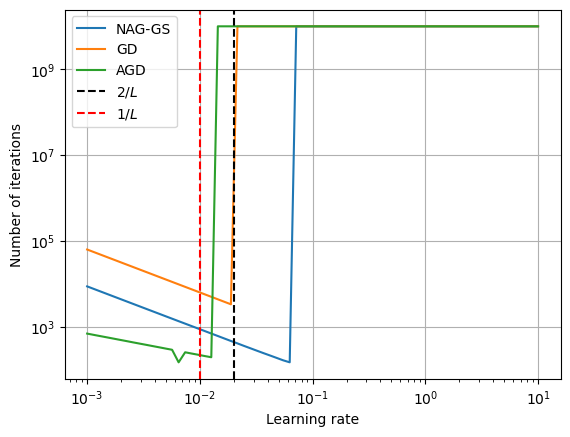

In [19]:
# plt.style.use("../iclr23.mplstyle")
plt.loglog(lr_range, num_iter_for_convergence["NAG-GS"], label="NAG-GS")
plt.loglog(lr_range, num_iter_for_convergence["GD"], label="GD")
plt.loglog(lr_range, num_iter_for_convergence["AGD"], label="AGD")
plt.axvline(x = 2/spectrum.max(), linestyle='--', color="black", label = '$2/L$')
plt.axvline(x = 1/spectrum.max(), linestyle='--', color="red", label = '$1/L$')
plt.grid(True)
# plt.axvline(x = 2/(spectrum.max() / spectrum.min()), linestyle='--', color="green", label = '$2/\kappa$')
plt.legend()
plt.xlabel("Learning rate")
plt.ylabel("Number of iterations")

In [20]:
np.savez("./quadratic_step_size_kappa1000", lr_range=lr_range, num_iter_for_convergence=num_iter_for_convergence,
         A=A, b=b)

## Check optimal learning rate

1) AGD and GD: $\alpha = 1 / L$

2) NAG-GS: $\alpha = \frac{2\mu + 2\sqrt{\mu L }}{L - \mu}$ if $\gamma = \mu$

In [44]:
torch.manual_seed(0)
n = 100
A = torch.randn(n, n).double()
Q, _ = torch.linalg.qr(A)
lmin = 1e-2
lmax = 100
Lambda = torch.linspace(lmin, lmax, steps=n).double()
A = Q @ torch.diag(Lambda) @ Q.t()
# A = A.t() @ A + torch.eye(n)
b = torch.randn(n).double()
spectrum = torch.linalg.eigvalsh(A)
print(spectrum)
print(spectrum.min().item(), spectrum.max().item(), spectrum.max().item() / 2, spectrum.max().item()/ spectrum.min().item())

tensor([1.0000e-02, 1.0200e+00, 2.0300e+00, 3.0400e+00, 4.0500e+00, 5.0600e+00,
        6.0700e+00, 7.0800e+00, 8.0900e+00, 9.1000e+00, 1.0110e+01, 1.1120e+01,
        1.2130e+01, 1.3140e+01, 1.4150e+01, 1.5160e+01, 1.6170e+01, 1.7180e+01,
        1.8190e+01, 1.9200e+01, 2.0210e+01, 2.1220e+01, 2.2230e+01, 2.3240e+01,
        2.4250e+01, 2.5260e+01, 2.6270e+01, 2.7280e+01, 2.8290e+01, 2.9300e+01,
        3.0310e+01, 3.1320e+01, 3.2330e+01, 3.3340e+01, 3.4350e+01, 3.5360e+01,
        3.6370e+01, 3.7380e+01, 3.8390e+01, 3.9400e+01, 4.0410e+01, 4.1420e+01,
        4.2430e+01, 4.3440e+01, 4.4450e+01, 4.5460e+01, 4.6470e+01, 4.7480e+01,
        4.8490e+01, 4.9500e+01, 5.0510e+01, 5.1520e+01, 5.2530e+01, 5.3540e+01,
        5.4550e+01, 5.5560e+01, 5.6570e+01, 5.7580e+01, 5.8590e+01, 5.9600e+01,
        6.0610e+01, 6.1620e+01, 6.2630e+01, 6.3640e+01, 6.4650e+01, 6.5660e+01,
        6.6670e+01, 6.7680e+01, 6.8690e+01, 6.9700e+01, 7.0710e+01, 7.1720e+01,
        7.2730e+01, 7.3740e+01, 7.4750e+

In [45]:
def quadratic_function(x):
    return 0.5 * x @ A @ x - b @ x

x_star = torch.linalg.solve(A, b)
f_star = quadratic_function(x_star)
x0 = torch.randn(n).double()

In [54]:
# NAG-GS run
divergence_tol = 1e5
eps = 1e-5
x = x0.clone()
x.requires_grad_(True)
conv_nag_gs = [x0.clone()]
alpha_nag_gs = (lmin + 2 * np.sqrt(lmin * lmax)) / (lmax - lmin)
print(alpha_nag_gs)
nag_gs = NAGGS([x], lr=alpha_nag_gs, mu=lmin, gamma=lmin)
current_iter = 0
while True:
    val = quadratic_function(x)
#     print((val - f_star).item())
    if abs(val - f_star) < eps:
        print("Converges for {} iterations".format(current_iter))
        break
    if abs(val - f_star) > divergence_tol:
        break
    val.backward()
    nag_gs.step()
    nag_gs.zero_grad()
    current_iter += 1
    conv_nag_gs.append(x.detach().clone())

0.0201020102010201
Converges for 565 iterations


In [55]:
# GD run
x = x0.clone()
x.requires_grad_(True)
conv_gd = [x0.clone()]
alpha_gd = 2 / (lmin + lmax)
print(alpha_gd)
sgd = torch.optim.SGD([x], lr=alpha_gd)
current_iter = 0
while True:
    val = quadratic_function(x)
#     print((val - f_star).item())
    if abs(val - f_star) < eps:
        print("Converges for {} iterations".format(current_iter))
        break
    if abs(val - f_star) > divergence_tol:
        break
    val.backward()
    sgd.step()
    sgd.zero_grad()
    current_iter += 1
    conv_gd.append(x.detach().clone())

0.01999800019998
Converges for 43553 iterations


In [56]:
# AGD run
alpha_agd = 1 / lmax
print(alpha_agd)
current_iter = 0
x = torch.clone(x0)
y = torch.clone(x0)
y.requires_grad_(True)

conv_agd = [x0.clone()]

current_iter = 0
while True:
    val_y = quadratic_function(y)
    val_x = quadratic_function(x)
#     print((val_x - f_star).item())
    if abs(val_x - f_star) < eps:
        print("Converges for {} iterations".format(current_iter))
        break
    if abs(val_x - f_star) > divergence_tol:
        break
    val_y.backward()
    with torch.no_grad():
        x_next = y - alpha_agd * y.grad
        y = x_next + current_iter / (current_iter + 3) * (x_next - x)
        x = x_next
    y.requires_grad_(True)
    current_iter += 1
    conv_agd.append(x.detach().clone())

0.01
Converges for 701 iterations


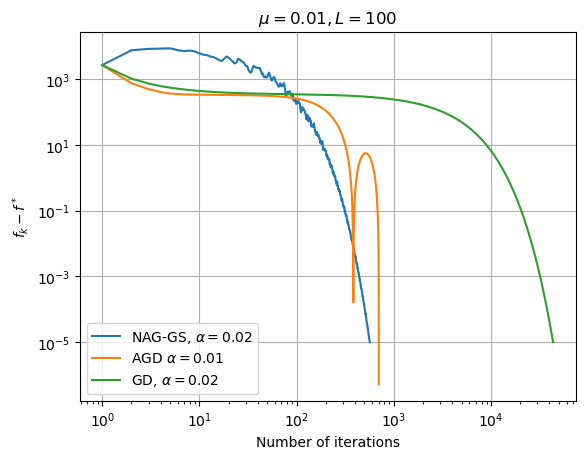

In [57]:
plt.semilogy(np.arange(1, len(conv_nag_gs) + 1), [quadratic_function(x).item() - f_star.item() for x in conv_nag_gs], label="NAG-GS, $\\alpha={}$".format(np.round(alpha_nag_gs, 3)))
plt.semilogy(np.arange(1, len(conv_agd) + 1), [quadratic_function(x).item() - f_star.item() for x in conv_agd], label="AGD $\\alpha={}$".format(np.round(alpha_agd, 3)))
plt.semilogy(np.arange(1, len(conv_gd) + 1), [quadratic_function(x).item() - f_star.item() for x in conv_gd], label="GD, $\\alpha={}$".format(np.round(alpha_gd, 3)))
plt.legend()
plt.xscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("$f_k - f^*$")
plt.title("$\mu = {}, L = {}$".format(lmin, lmax))
plt.grid(True)

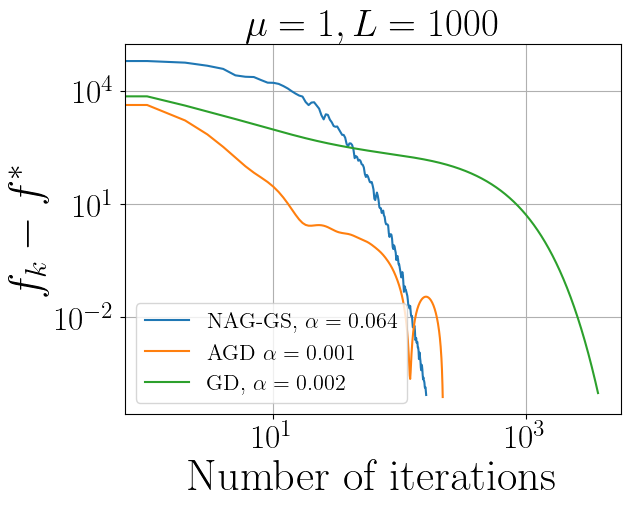

In [271]:
plt.semilogy([quadratic_function(x).item() - f_star for x in conv_nag_gs], label="NAG-GS, $\\alpha={}$".format(np.round(alpha_nag_gs, 3)))
plt.semilogy([quadratic_function(x) - f_star for x in conv_agd], label="AGD $\\alpha={}$".format(np.round(alpha_agd, 3)))
plt.semilogy([quadratic_function(x).item() - f_star for x in conv_gd], label="GD, $\\alpha={}$".format(np.round(alpha_gd, 3)))
plt.legend(fontsize=16)
plt.xscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("$f_k - f^*$")
plt.title("$\mu = {}, L = {}$".format(lmin, lmax))
plt.grid(True)

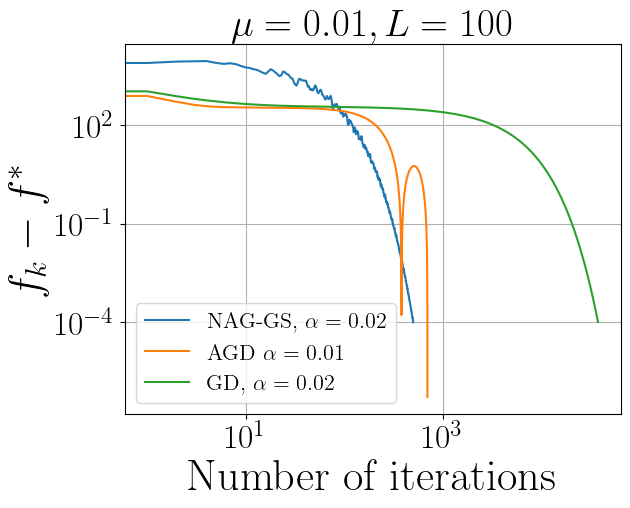

In [284]:
plt.semilogy([quadratic_function(x).item() - f_star for x in conv_nag_gs], label="NAG-GS, $\\alpha={}$".format(np.round(alpha_nag_gs, 3)))
plt.semilogy([quadratic_function(x) - f_star for x in conv_agd], label="AGD $\\alpha={}$".format(np.round(alpha_agd, 3)))
plt.semilogy([quadratic_function(x).item() - f_star for x in conv_gd], label="GD, $\\alpha={}$".format(np.round(alpha_gd, 3)))
plt.legend(fontsize=16)
plt.xscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("$f_k - f^*$")
plt.title("$\mu = {}, L = {}$".format(lmin, lmax))
plt.grid(True)